# General data reader for AQUA 
## Time averaging

Input data may not be available at the desired time frequency. It is possible to perform time averaging at a given frequency (currently daily and monthly are implemented) using the `timmean()` method of the reader. It would in theory be possible also to specify averaging already when instantiating the reader, but this may not be the most efficient choice.

In [2]:
from aqua import Reader

Here we demonstrate the functionality for sample IFS data which at the same time are also regridded to a desired 1°x1° grid. 

In [8]:
reader = Reader(model="MSWEP", exp="past", source="daily", regrid="r100")
data = reader.retrieve()
data

/LUMI_TYKKY_ZOMGa5S/miniconda/envs/env1/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
2024-02-12 20:38:29 :: eccodes :: WARNING  -> ShortName tprate has multiple grib codes associated: ['260048', '172228']
2024-02-12 20:38:29 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right


<xarray.Dataset>
Dimensions:  (time: 15339, lat: 1800, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2020-12-30
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
Data variables:
    tprate   (time, lat, lon) float32 dask.array<chunksize=(23, 105, 450), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Tue May 23 21:05:25 2023: cdo -f nc mergetime 1979002.nc 19...

These data are still at the original (hourly) frequency. Let's time average just the surface temperatures (the original data in this case). We specify the regridding frequency with the `freq` keyword. :

In [9]:
daily = reader.timmean(data['tprate'], freq = 'daily')
daily

<xarray.DataArray 'tprate' (time: 15339, lat: 1800, lon: 3600)>
dask.array<stack, shape=(15339, 1800, 3600), dtype=float32, chunksize=(1, 113, 450), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * time     (time) datetime64[ns] 1979-01-02 1979-01-03 ... 2020-12-30
Attributes:
    units:        kg m**-2 s**-1
    history:      \n2024-02-12 20:38:29 AQUA💧: Variable renamed tprate by fix...
    paramId:      260048
    long_name:    Total precipitation rate
    cfVarName:    tprate
    shortName:    tprate
    factor:       1.1574074074074072e-05
    offset:       0
    src_units:    mm d-1
    units_fixed:  1

Data have now been averaged at the daily timescale. We can proceed and regrid them

In [21]:
tas = reader.regrid(daily.isel(time=10))
tas

<xarray.DataArray 'tprate' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 1979-01-12
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    units:        kg m**-2 s**-1
    history:      \n2024-02-12 20:38:29 AQUA💧: Variable renamed tprate by fix...
    paramId:      260048
    long_name:    Total precipitation rate
    cfVarName:    tprate
    shortName:    tprate
    factor:       1.1574074074074072e-05
    offset:       0
    src_units:    mm d-1
    units_fixed:  1
    regridded:    1

In [22]:
tas = tas*86400
tas.attrs['units']='mm/day'

And we call the plot. This might takes a bit of time, since the files need to be loaded. Dask should be reasonably efficient calling only the frames that we need to create the time averaging. 

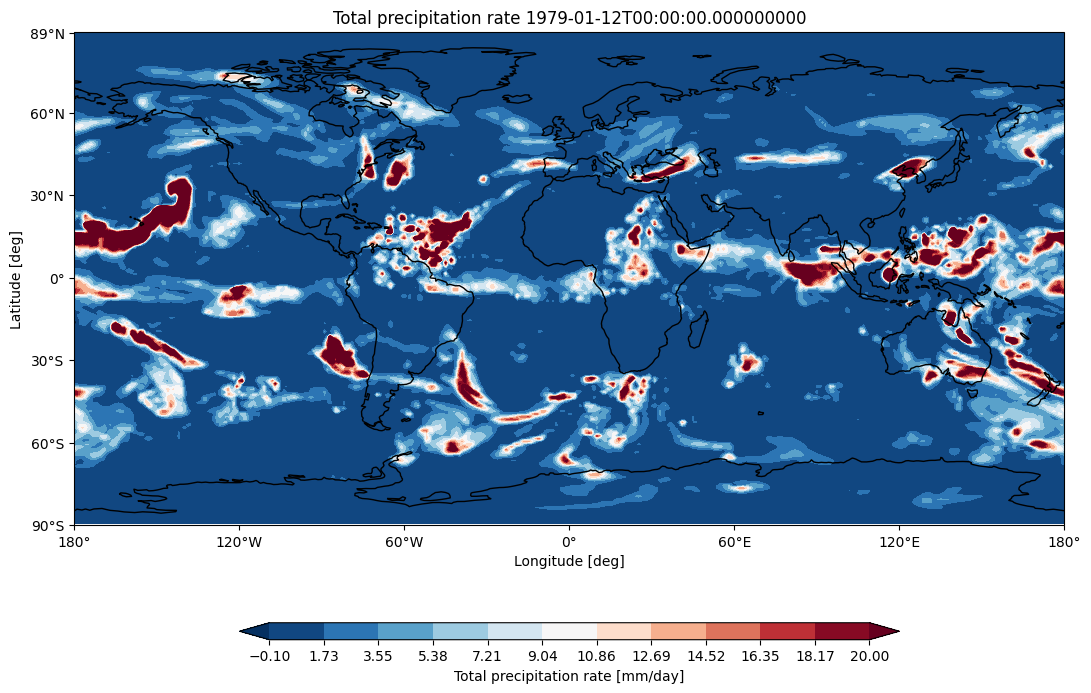

In [24]:
tas.aqua.plot_single_map(vmin=-0.1, vmax=20, nticks=4)